In [4]:
import scipy
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import os

# skimage
import skimage
import skimage.color
import skimage.transform
import skimage.feature
import skimage.io

In [3]:
from sklearn.base import BaseEstimator,TransformerMixin
class rgb2gray_transform(BaseEstimator,TransformerMixin):
    import skimage.color
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return np.array([skimage.color.rgb2gray(x) for x in X])
    
class hogtransformer(BaseEstimator,TransformerMixin):
    import skimage.feature
    def __init__(self,orientations=9,pixels_per_cell=(8, 8),cells_per_block=(3, 3),):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        def local_hog(img):
            hog_features= skimage.feature.hog(img,orientations=self.orientations,
                                pixels_per_cell=self.pixels_per_cell,
                                cells_per_block=self.cells_per_block)
            
            return hog_features
        
        hfeatures = np.array([local_hog(x) for x in X])
        return hfeatures

In [5]:
# pipeline model
image = skimage.io.imread('eagle.jpg')
# transform image into 80 x 80
image_resize = skimage.transform.resize(image,(80,80)) 
image_scale = 255*image_resize
image_transform = image_scale.astype(np.uint8)
# rgb to gray
gray = skimage.color.rgb2gray(image_transform)
# hog feature
feature_vector = skimage.feature.hog(gray,orientations=10,pixels_per_cell=(8,8),cells_per_block=(2,2))

In [7]:
feature_vector

array([0.19801825, 0.14617992, 0.12000975, ..., 0.0459591 , 0.04528046,
       0.00672236])

In [8]:
# load the model
model = pickle.load(open('dsa_image_classification_sgd.pickle','rb'))
scaler = pickle.load(open('dsa_scaler.pickle','rb'))

In [9]:
model.get_params()

{'alpha': 0.01,
 'average': False,
 'class_weight': None,
 'early_stopping': True,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [11]:
scalex = scaler.transform(feature_vector.reshape(1,-1))
result = model.predict(scalex)

In [12]:
result

array(['eagle'], dtype='<U8')

In [15]:
# calculate the probability
desicion_value = model.decision_function(scalex)

In [16]:
desicion_value

array([[-151.15014372, -185.66131155, -130.33557941, -180.39661515,
        -250.31365251, -198.74929947,  -13.21809899,    0.42303014,
        -226.19021161, -154.02355468, -231.34417865,  -54.04559198,
        -271.00883218, -219.98209389,  -71.56603805,  -43.07498092,
        -175.01583336, -158.41403915, -156.11285067, -324.78620353]])

In [20]:
labels = model.classes_

In [19]:
desicion_value = desicion_value.flatten()

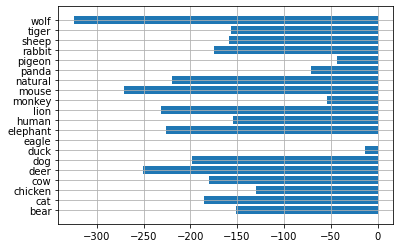

In [23]:
plt.barh(labels, desicion_value)
plt.grid()

In [26]:
# calculate z-score
z = scipy.stats.zscore(desicion_value)
prob_value = scipy.special.softmax(z)
prob_value

array([0.03332697, 0.02220622, 0.04257353, 0.02362504, 0.01037909,
       0.01903737, 0.16885157, 0.19824355, 0.01378505, 0.03221924,
       0.01297407, 0.10445114, 0.00813627, 0.01482949, 0.08499618,
       0.11884015, 0.02516886, 0.03059736, 0.03143699, 0.00432186])

In [31]:
# top 5 probability values
top_5_prob_index = prob_value.argsort()[::-1][:5]

In [32]:
top_5_prob_index

array([ 7,  6, 15, 11, 14], dtype=int64)

In [34]:
top_labels = labels[top_5_prob_index]
top_prob = prob_value[top_5_prob_index]

In [35]:
top_prob,top_labels

(array([0.19824355, 0.16885157, 0.11884015, 0.10445114, 0.08499618]),
 array(['eagle', 'duck', 'pigeon', 'monkey', 'panda'], dtype='<U8'))

In [38]:
top_dict = dict()
for key,val in zip(top_labels,top_prob):
    top_dict.update({key:np.round(val,3)})

In [39]:
top_dict

{'eagle': 0.198,
 'duck': 0.169,
 'pigeon': 0.119,
 'monkey': 0.104,
 'panda': 0.085}

In [40]:
def pipeline_model(path, scaler_transform, model_sgd):
    # pipeline model
    image = skimage.io.imread('eagle.jpg')
    # transform image into 80 x 80
    image_resize = skimage.transform.resize(image,(80,80)) 
    image_scale = 255*image_resize
    image_transform = image_scale.astype(np.uint8)
    # rgb to gray
    gray = skimage.color.rgb2gray(image_transform)
    # hog feature
    feature_vector = skimage.feature.hog(gray,orientations=10,pixels_per_cell=(8,8),cells_per_block=(2,2))
   
    # scaling
    scalex = scaler.transform(feature_vector.reshape(1,-1))
    result = model.predict(scalex)
    
    # decision function # confidence
    desicion_value = model.decision_function(scalex).flatten()
    labels = model_sgd.classes_
    # probability
    z = scipy.stats.zscore(desicion_value)
    prob_value = scipy.special.softmax(z)
    
    # top 5
    top_5_prob_ind = prob_value.argsort()[::-1][:5]
    top_labels = labels[top_5_prob_ind]
    top_prob = prob_value[top_5_prob_ind]
    # put in dictionary
    top_dict = dict()
    for key,val in zip(top_labels,top_prob):
        top_dict.update({key:np.round(val,3)})
    return top_dict

In [41]:
res = pipeline_model('eagle.jpg',scaler,model)
res

{'eagle': 0.198,
 'duck': 0.169,
 'pigeon': 0.119,
 'monkey': 0.104,
 'panda': 0.085}